In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [15]:
# Define folder paths for each batting shot category
folders = {
    "cover_drive": "./cover_drive",
    "pull_shot": "./pull_shot",
    "wrong_shot": "./wrong_shot"
}

In [16]:
# Initialize data and labels
data = []
labels = []

In [17]:
# Label mapping
label_map = {folder: label for label, folder in enumerate(folders.keys())}

In [18]:
# Load and preprocess data
for label, folder_path in enumerate(folders.values()):
    print(f"Processing folder: {folder_path}, Label: {label}")

    for file in os.listdir(folder_path):
        if file.endswith(".xlsx"):
            file_path = os.path.join(folder_path, file)
            
            # Load Excel data
            df = pd.read_excel(file_path)

            # Extract features (flattened time, shoulder, and elbow data)
            try:
                features = df[["Time", "LShoulder_Avg", "LElbow_Avg"]].values.flatten()
                data.append(features)
                labels.append(label)
            except KeyError:
                print(f"Missing columns in {file_path}, skipping this file.")

Processing folder: ./cover_drive, Label: 0
Processing folder: ./pull_shot, Label: 1
Processing folder: ./wrong_shot, Label: 2


In [19]:
# Padding to ensure equal-length features
max_length = max(len(row) for row in data)
data_padded = [np.pad(row, (0, max_length - len(row)), constant_values=0) for row in data]

In [20]:
# Convert to NumPy arrays
data_array = np.array(data_padded)
labels_array = np.array(labels)

In [8]:
# Normalize data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_array)

In [21]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_normalized, labels_array, test_size=0.3, random_state=42)

In [22]:
# Train the model
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [23]:
# Evaluate the model
y_pred = model.predict(X_test)

In [24]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[29  9  3]
 [ 6 26  2]
 [ 0  2  8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.76        41
           1       0.70      0.76      0.73        34
           2       0.62      0.80      0.70        10

    accuracy                           0.74        85
   macro avg       0.72      0.76      0.73        85
weighted avg       0.75      0.74      0.74        85


Accuracy Score: 0.7411764705882353


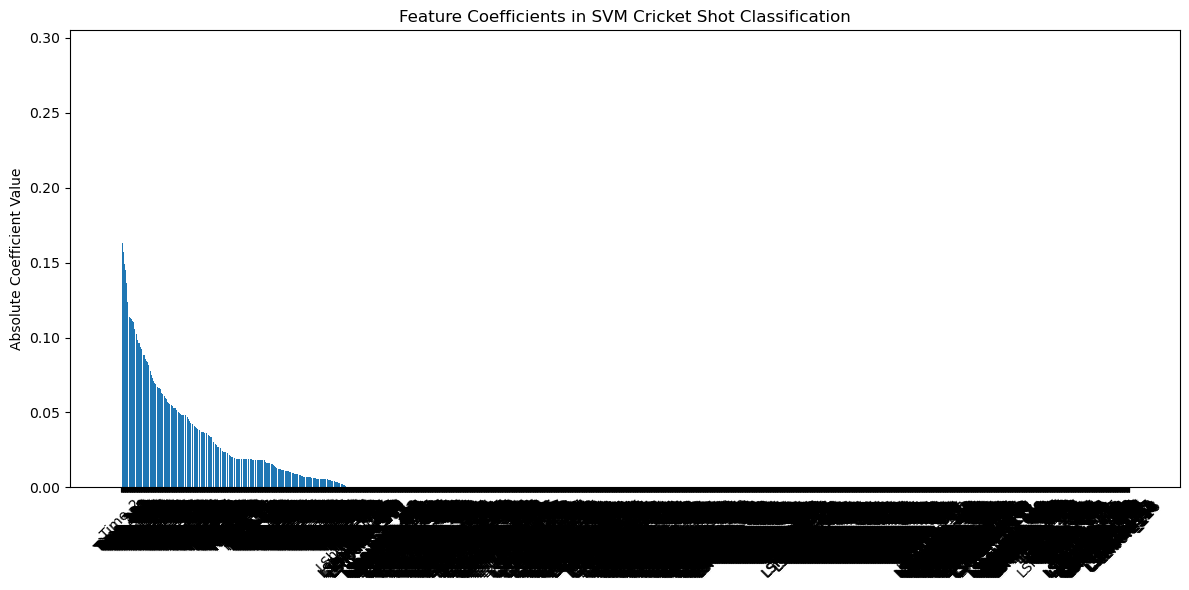

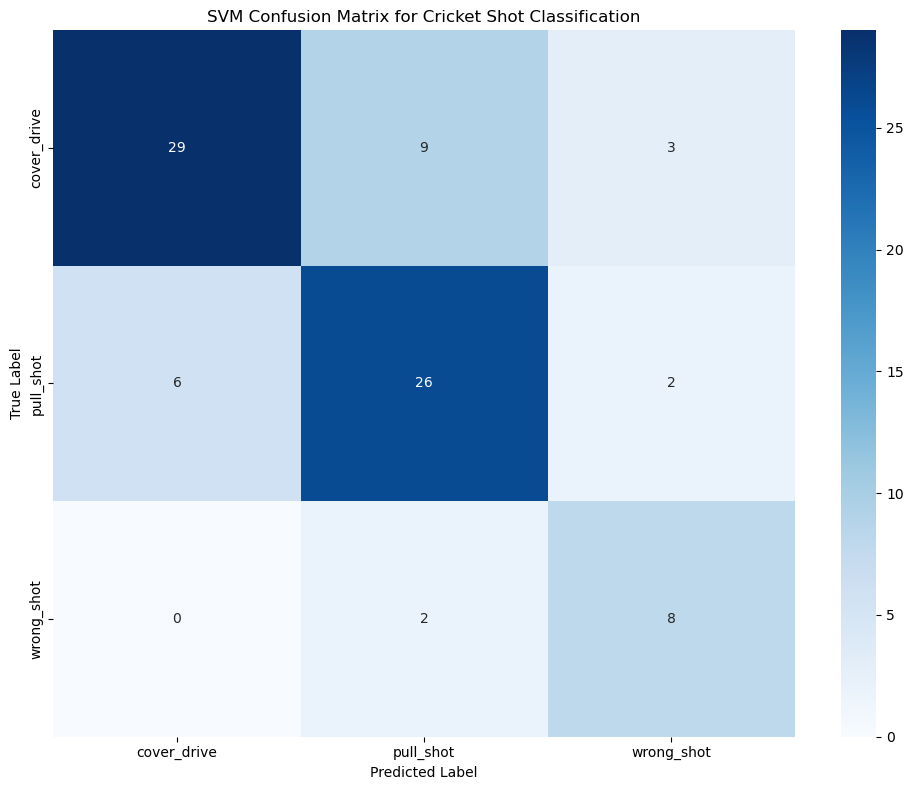

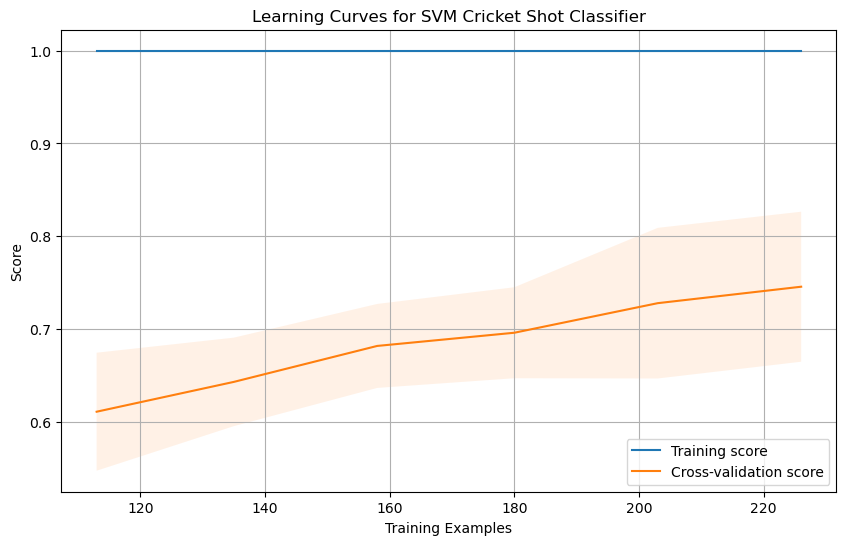

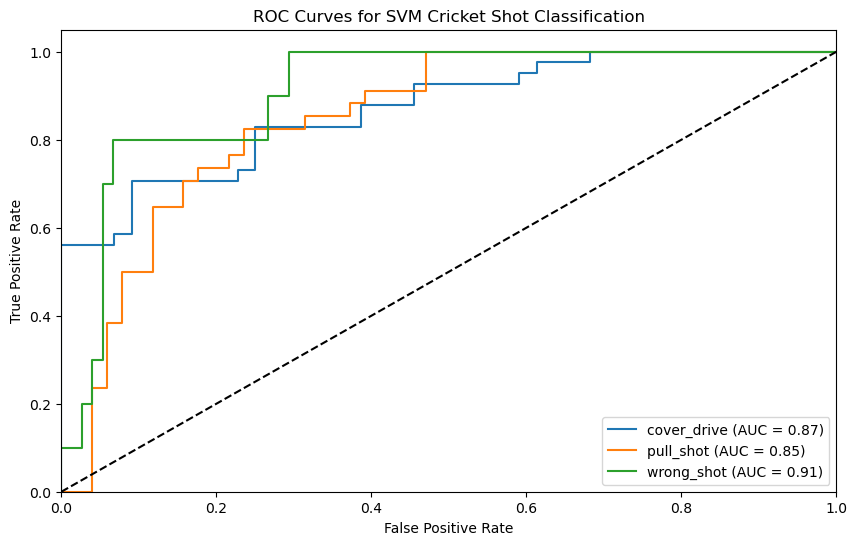


===== SVM Model Performance Metrics =====

Overall Accuracy: 0.7412

Detailed Performance Metrics by Class:

Classification Report:
              precision    recall  f1-score   support

 cover_drive       0.83      0.71      0.76        41
   pull_shot       0.70      0.76      0.73        34
  wrong_shot       0.62      0.80      0.70        10

    accuracy                           0.74        85
   macro avg       0.72      0.76      0.73        85
weighted avg       0.75      0.74      0.74        85


Confusion Matrix:
             cover_drive  pull_shot  wrong_shot
cover_drive           29          9           3
pull_shot              6         26           2
wrong_shot             0          2           8

Detailed Metrics per Class:

cover_drive:
Precision: 0.8286
Recall: 0.7073
F1-Score: 0.7632
Support: 41

pull_shot:
Precision: 0.7027
Recall: 0.7647
F1-Score: 0.7324
Support: 34

wrong_shot:
Precision: 0.6154
Recall: 0.8000
F1-Score: 0.6957
Support: 10

SVM Model Informatio

In [25]:
# 1. SVM Coefficient Visualization (for linear kernel)
def plot_feature_importance_svm(model, feature_names):
    if hasattr(model, 'coef_'):
        # For linear kernel
        importances = np.abs(model.coef_[0])  # Using first class for binary classification
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 6))
        plt.title('Feature Coefficients in SVM Cricket Shot Classification')
        plt.bar(range(len(indices)), importances[indices])
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
        plt.ylabel('Absolute Coefficient Value')
        plt.tight_layout()
        plt.show()
    else:
        print("Feature importance visualization is only available for linear kernel")

# 2. Confusion Matrix Heatmap
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('SVM Confusion Matrix for Cricket Shot Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# 3. Learning Curves
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curves for SVM Cricket Shot Classifier')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# 4. ROC Curves
def plot_roc_curves(model, X_test, y_test, classes):
    # Get decision function scores for ROC curve
    if hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)
    
    y_test_bin = label_binarize(y_test, classes=range(len(classes)))
    
    # Handle multi-class case
    if len(classes) > 2:
        y_score = np.column_stack([y_score, -np.sum(y_score, axis=1)])
    
    plt.figure(figsize=(10, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for SVM Cricket Shot Classification')
    plt.legend(loc="lower right")
    plt.show()

# Create feature names for visualization
time_points = len(data_array[0]) // 3
feature_names = (
    [f'Time_{i}' for i in range(time_points)] +
    [f'LShoulder_{i}' for i in range(time_points)] +
    [f'LElbow_{i}' for i in range(time_points)]
)

# Generate all visualizations
classes = list(folders.keys())

# Plot feature coefficients (for linear kernel)
plot_feature_importance_svm(model, feature_names)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, classes)

# Plot learning curves
plot_learning_curves(model, data_normalized, labels_array)

# Plot ROC curves
plot_roc_curves(model, X_test, y_test, classes)

# Print Model Performance Metrics
print("\n===== SVM Model Performance Metrics =====\n")

# Print overall accuracy
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Print detailed classification report
print("\nDetailed Performance Metrics by Class:")
print("\nClassification Report:")
report = classification_report(y_test, y_pred, target_names=classes)
print(report)

# Print confusion matrix with labels
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print(cm_df)

# Print additional metrics per class
print("\nDetailed Metrics per Class:")
cr = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
for shot_type in classes:
    print(f"\n{shot_type}:")
    print(f"Precision: {cr[shot_type]['precision']:.4f}")
    print(f"Recall: {cr[shot_type]['recall']:.4f}")
    print(f"F1-Score: {cr[shot_type]['f1-score']:.4f}")
    print(f"Support: {cr[shot_type]['support']}")

# Print SVM-specific information
print("\nSVM Model Information:")
print(f"Number of Support Vectors: {model.n_support_}")
print(f"Support Vector indices: {model.support_}")

In [13]:
# Save the trained model and scaler for future use
joblib.dump(model, "batting_shot_classifier.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!


In [14]:
import os
import pandas as pd
import numpy as np
import joblib

In [76]:
# Load the trained model and scaler
model = joblib.load("batting_shot_classifier.pkl")
scaler = joblib.load("scaler.pkl")

In [77]:
# Define label mapping for interpretation
label_map = {0: "cover_drive", 1: "pull_shot", 2: "wrong_shot"}

In [81]:
# Path to the test Excel file
test_file_path = "./combined_Lsh_LEl_angles_Multiprocessing_BasedonTime_7.xlsx"  # Update with the actual path of your Excel file

In [82]:
# Function to preprocess and predict the category of the shot
def predict_shot(file_path):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return
    
    try:
        # Load the Excel data
        df = pd.read_excel(file_path)

        # Check for necessary columns
        if not {"Time", "LShoulder_Avg", "LElbow_Avg"}.issubset(df.columns):
            print("The Excel file is missing required columns: 'Time', 'LShoulder_Avg', 'LElbow_Avg'")
            return

        # Extract features and flatten
        features = df[["Time", "LShoulder_Avg", "LElbow_Avg"]].values.flatten()

        # Pad features to match training data length
        max_length = scaler.mean_.shape[0]
        features_padded = np.pad(features, (0, max_length - len(features)), constant_values=0)

        # Normalize the features
        features_normalized = scaler.transform([features_padded])

        # Predict the category
        prediction = model.predict(features_normalized)
        predicted_label = label_map[prediction[0]]

        print(f"The predicted batting shot category is: {predicted_label}")
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")


In [83]:
# Test the model with the Excel file
predict_shot(test_file_path)

The predicted batting shot category is: pull_shot
